# 미니 프로젝트 : Movielens 영화 Session Based Recommendation

`Movielens 1M Dataset` 을 기반으로, Session based Recommendation 시스템을 구현해보자.

## 0. 필요한 라이브러리 불러오기

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 1. 데이터 불러오기

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


데이터 정보
- 명확한 1회 세션의 SessionID 를 포함하지 않고 있어 UserID 가 SessionID 의 역할을 해야함
- Rating 정보 포함 -> Rating 정보를 어떻게 처리할지
- Time 항목에는 UTC time 이 포함. 1970년 1월 1일 부터 경과된 초단위 시간이 기재

----
## 2. 데이터 전처리

### 2.1. 유저수와 아이템 수 확인

In [3]:
print(f"유저수 : {data['UserId'].nunique()}")
print(f"아이템 수 : {data['ItemId'].nunique()}")

유저수 : 6040
아이템 수 : 3706


### 2.2 Session 구분
기본적으로 세션은 30분 이상 아무 활동이 없을 때까지 지속 된다.

따라서 아래의 방법으로 세션을 구분한다.

- 유저별, 시간별 정렬
- 현재 행의 UseId 와 이전 행의 UseId 가 다르다면, 유저가 다른 것이므로 현재 행을 새로운 세션으로 취급
- 현재 행의 Time 과 이전 행의 Time 의 차이가 1800 (30분) 보다 크다면 유저가 30분 동안 아무 활동이 없는 것이므로 현재 행의 활동을 새로운 세션으로 취급

In [4]:
session = data[['UserId', 'Time']]

In [5]:
# session dataframe 의 index 를 순서대로 초기화
session.reset_index(drop= True, inplace=True)

In [6]:
session

,UserId,Time
0,1,978300019
1,1,978300055
2,1,978300055
3,1,978300055
4,1,978300103
...,...,...
1000204,6040,997454429
1000205,6040,997454464
1000206,6040,997454464
1000207,6040,997454486


In [7]:
# 이전 활동의 행과 같은 유저의 활동인지 체크
session['Id_match'] = session.UserId.eq(session.UserId.shift())

# 이전 행과의 시간 차이 (초)
session['Time_diff'] = session['Time'] - session.Time.shift()

# 첫 줄의 SessionId 지정
session.loc[0,['SessionId']] = 0

In [8]:
session

,UserId,Time,Id_match,Time_diff,SessionId
0,1,978300019,False,NaN,0.0
1,1,978300055,True,36.0,NaN
2,1,978300055,True,0.0,NaN
3,1,978300055,True,0.0,NaN
4,1,978300103,True,48.0,NaN
...,...,...,...,...,...
1000204,6040,997454429,True,31.0,NaN
1000205,6040,997454464,True,35.0,NaN
1000206,6040,997454464,True,0.0,NaN
1000207,6040,997454486,True,22.0,NaN


In [9]:
def sessionize(id_match, time_diff):
    global session_id
    if (id_match==False) or (time_diff>1800):
        session_id = session_id + 1
    
    return session_id

In [10]:
session_id = session.loc[0,'SessionId']
session.loc[1:, 'SessionId'] = session.loc[1:].apply(lambda row:sessionize(*row[['Id_match','Time_diff']]), axis=1)
session

,UserId,Time,Id_match,Time_diff,SessionId
0,1,978300019,False,NaN,0.0
1,1,978300055,True,36.0,0.0
2,1,978300055,True,0.0,0.0
3,1,978300055,True,0.0,0.0
4,1,978300103,True,48.0,0.0
...,...,...,...,...,...
1000204,6040,997454429,True,31.0,25161.0
1000205,6040,997454464,True,35.0,25161.0
1000206,6040,997454464,True,0.0,25161.0
1000207,6040,997454486,True,22.0,25161.0


In [11]:
print(f"세션 수 : {session['SessionId'].nunique()}")

세션 수 : 25163


위의 과정으로 세션을 나누고 총 약 2만5천개의 세션으로 나누어진 것을 확인 할 수 있다.

나누어진 세션 정보를 `data` 에 추가한다.

In [12]:
# UserId, Time 을 기준으로 병합
data = pd.merge(data, session[['UserId', 'Time', 'SessionId']], on=['UserId', 'Time'])

# 중복제거
data.drop_duplicates(inplace=True)
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0.0
1,1,1270,5,978300055,0.0
4,1,1721,4,978300055,0.0
7,1,1022,5,978300055,0.0
10,1,2340,3,978300103,0.0
...,...,...,...,...,...
3250730,6040,2917,4,997454429,25161.0
3250731,6040,1921,4,997454464,25161.0
3250733,6040,1784,3,997454464,25161.0
3250735,6040,161,3,997454486,25161.0


In [13]:
# SessionId 정수로 변경
data = data.astype({'SessionId': 'int'})

# index 초기화
data.reset_index(drop= True, inplace=True)
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,0
2,1,1721,4,978300055,0
3,1,1022,5,978300055,0
4,1,2340,3,978300103,0
...,...,...,...,...,...
1000204,6040,2917,4,997454429,25161
1000205,6040,1921,4,997454464,25161
1000206,6040,1784,3,997454464,25161
1000207,6040,161,3,997454486,25161


### 2.3. Session Length

`SessionId` 를 공유하는 데이터 row 개수를 `session_length` 에 저장한다.

여기서 `session_length` 는 해당 세션의 사용자가 그 세션 동안 몇번의 액션을 취했는지의 의미한다.

In [14]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         40
1         13
2        129
3         51
4         21
        ... 
25158      7
25159     14
25160      1
25161     21
25162      1
Length: 25163, dtype: int64

In [15]:
session_length.median(), session_length.mean()

(6.0, 39.74919524698963)

In [16]:
session_length.min(), session_length.max()

(1, 1193)

In [17]:
session_length.quantile(0.95)

186.0

- 최소 길이는 1, 최대 길이는 1193
- 95%의 세션의 길이는 186 이하

Text(0.5, 1.0, 'PDF of Session length')

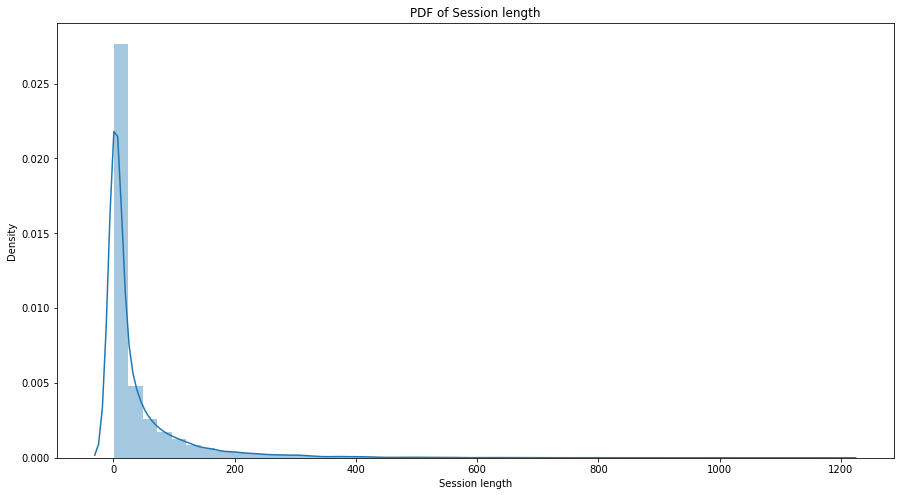

In [18]:
f,ax = plt.subplots(1,1, figsize=(15,8))
sns.distplot(session_length, ax=ax)
plt.xlabel('Session length')
plt.ylabel('Density')
plt.title('PDF of Session length')

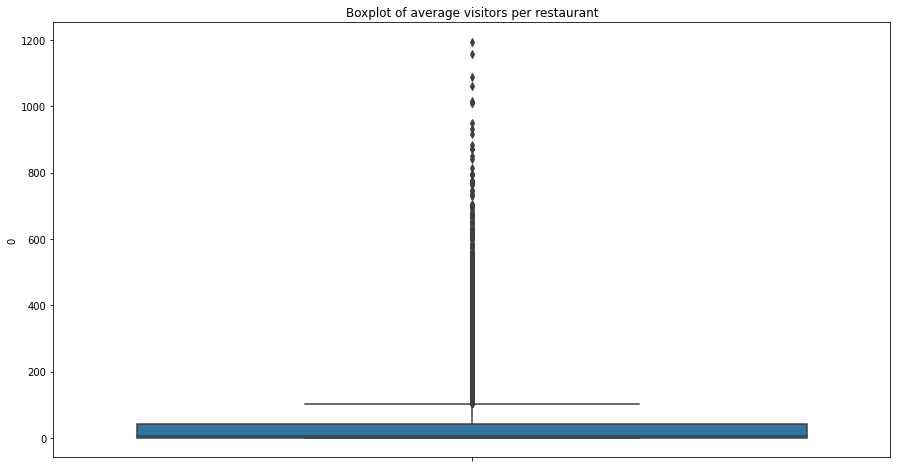

In [19]:
temp = data.groupby('SessionId').size().to_frame()

f,ax = plt.subplots(1,1, figsize=(15,8))
sns.boxplot(y=0 , data=temp, ax=ax)
plt.title('Boxplot of average visitors per restaurant')
plt.show()

세션길이 기준 하위 95%까지의 분포 누적합을 시각화해보자.

In [20]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_95 = length_percent_cumsum[length_percent_cumsum < 0.95]

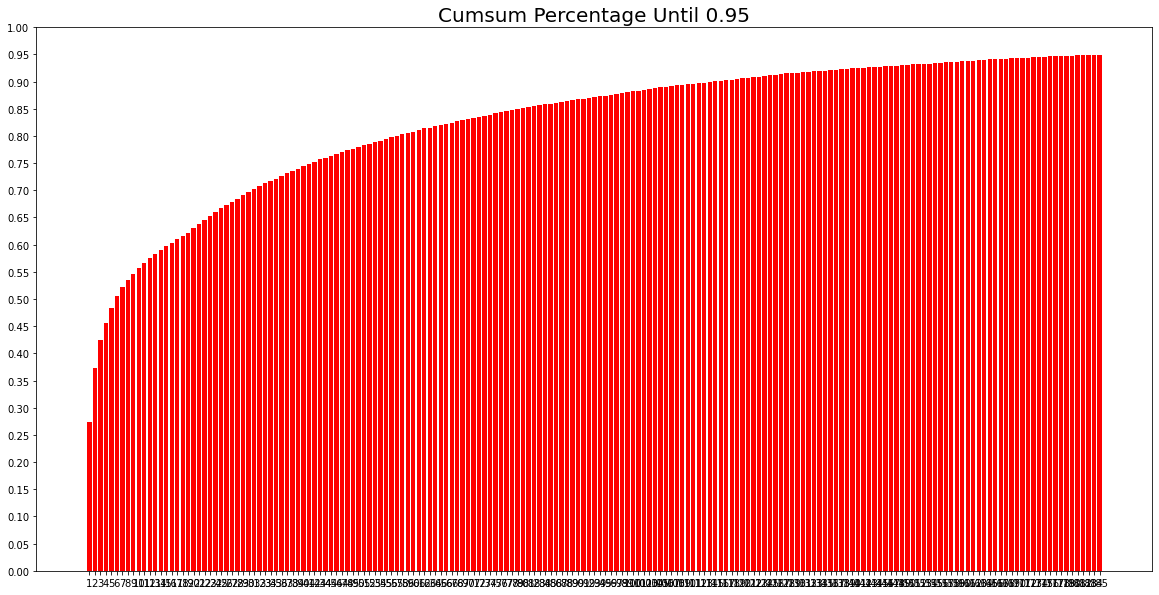

In [21]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_95.index,
        height=length_percent_cumsum_95, color='red')
plt.xticks(length_percent_cumsum_95.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.95', size=20)
plt.show()

### 2.4. Session Time

In [22]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(dt.datetime.utcfromtimestamp(oldest).strftime('%Y-%m-%d %H:%M:%S'))
print(dt.datetime.utcfromtimestamp(latest).strftime('%Y-%m-%d %H:%M:%S'))

2000-04-25 23:05:32
2003-02-28 17:49:50


### 2.5. 데이터 정제 Data Cleansing

- Rating 이 2 이하인 데이터는 선호하지 않는 것으로 판단하여 삭제

In [23]:
# 세션 길이가 1인 데이터 삭제
session_use = session_length[session_length >= 2].index
data = data[data['SessionId'].isin(session_use)]

In [24]:
# Rating 이 2 이하인 데이터 삭제
idx_rating = data[data['Rating']<3].index
data = data.drop(idx_rating)

data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,0
2,1,1721,4,978300055,0
3,1,1022,5,978300055,0
4,1,2340,3,978300103,0
...,...,...,...,...,...
1000203,6040,232,5,997454398,25161
1000204,6040,2917,4,997454429,25161
1000205,6040,1921,4,997454464,25161
1000206,6040,1784,3,997454464,25161


## 2.6. Train/ Valid/ Test split
모델 평가를 위해 Train Set, Valid Set과 Test Set을 만든다.

추천 시스템은 지금 잘 예측하는 게 중요 하기 때문에 기간에 따라 Train/ Valid/ Test 셋을 나누겠다.

가장 마지막 30일 기간 동안을 test set으로, 그 이전 30일을 valid set으로 사용한다.

In [25]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - (86400*n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - (86400*n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [26]:
tr, test = split_by_date(data, n_days=100)
tr, val = split_by_date(tr, n_days=100)

In [27]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    first_time = dt.datetime.utcfromtimestamp(data["Time"].min()).strftime('%Y-%m-%d %H:%M:%S')
    last_time = dt.datetime.utcfromtimestamp(data["Time"].max()).strftime('%Y-%m-%d %H:%M:%S')
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {first_time}\n'
          f'\t Last Time : {last_time}\n')

In [28]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 822783
	 Sessions: 6038
	 Items: 3618
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-08-12 13:53:29

* valid Set Stats Info
	 Events: 3973
	 Sessions: 174
	 Items: 1633
	 First Time : 2002-08-13 09:05:17
	 Last Time : 2002-11-20 16:38:40

* test Set Stats Info
	 Events: 3780
	 Sessions: 192
	 Items: 1542
	 First Time : 2002-11-21 01:02:06
	 Last Time : 2003-02-28 17:49:50



In [29]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [30]:
# 전처리가 완료된 데이터를 저장합니다.
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 3. Data Pipeline

### 3.1. SessionDataset
데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만든다.

In [31]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [32]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,978300019,0,0
1,1,1270,5,978300055,0,1
2,1,1721,4,978300055,0,2
3,1,1022,5,978300055,0,3
4,1,2340,3,978300103,0,4
5,1,1836,5,978300172,0,5
6,1,3408,4,978300275,0,6
7,1,2804,5,978300719,0,7
8,1,1207,4,978300719,0,8
9,1,1193,5,978300760,0,9


### 3.2. SessionDataLoader

`SessionDataset` 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만든다.

- `__iter__` 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 `yield` 함
- `mask` 는 이후에 RNN Cell State를 초기화 하는데 사용

In [33]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [34]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=50)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
0,1,3186,4,978300019,0,0
1,1,1270,5,978300055,0,1
2,1,1721,4,978300055,0,2
3,1,1022,5,978300055,0,3
4,1,2340,3,978300103,0,4
5,1,1836,5,978300172,0,5
6,1,3408,4,978300275,0,6
7,1,2804,5,978300719,0,7
8,1,1207,4,978300719,0,8
9,1,1193,5,978300760,0,9


In [35]:
iter_ex = iter(tr_data_loader)

In [36]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [   0   40   53   64   54  201  325    1   54  458  370   72  702  718
   53  185  414  753   37  782  789  406  845  855  672  897  378 1003
   28  272   15  461 1030   60   16 1032  948   76 1051  882  579  324
  201 1091 1133   87  279 1160  393   64]
Label Item Idx are :       [   1   41   54   62   24   12  135  127  381   15  492  664  703  719
  536   97  106  754  171  783   53  832  528    9  642   64  319  284
  792  133  463  183  936  506  234 1033 1034 1038  551 1079  692  992
 1089 1036 1008  163 1158   53  458 1145]
Previous Masked Input Idx are [16]


In [37]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [   1   41   54   62   24   12  135  127  381   15  492  664  703  719
  536   97  106  754  171  783   53  832  528    9  642   64  319  284
  792  133  523  183 1278  493  234 1033 1034 1038  551 1079  692  992
 1089 1036 1008  163 1158   53  458 1145]
Label Item Idx are :       [   2   42   55  162   66  202  326  150  201  326  493  120   59   42
  724  329   47  755  761  784  183  410  419  856  765   41  842  227
  203   31 1241  474   87  483  284   62  907   54  475  470  620   24
   64 1092  503  350 1159  152  429 1168]
Previous Masked Input Idx are [30 32 33]


## 4. 모델 구성

### 4.1. Evaluation Metric
모델 성능에 대한 지표로 __MRR__ 과 __Recall@k__ (recall의 개념을 확장) 를 사용

In [38]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 4.2. Model Architecture

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [40]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [41]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [42]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3618)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    550500    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3618)               184518    
Total params: 735,018
Trainable params: 735,018
Non-trainable params: 0
_________________________________________________________________


----
## 5. 모델 학습

In [43]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [44]:
train_model(model, args)

Train:   0%|          | 0/6291 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.09] 

	 - Recall@20 epoch 1: 0.062500
	 - MRR@20    epoch 1: 0.016572



Train:   0%|          | 0/6291 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.8]  

	 - Recall@20 epoch 2: 0.085938
	 - MRR@20    epoch 2: 0.022021



Train:   0%|          | 0/6291 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.58]

	 - Recall@20 epoch 3: 0.108259
	 - MRR@20    epoch 3: 0.024587



Train:   0%|          | 0/6291 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.59] 

	 - Recall@20 epoch 4: 0.112723
	 - MRR@20    epoch 4: 0.026424



Train:   0%|          | 0/6291 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.52] 

	 - Recall@20 epoch 5: 0.110491
	 - MRR@20    epoch 5: 0.027445



Train:   0%|          | 0/6291 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.51] 

	 - Recall@20 epoch 6: 0.111607
	 - MRR@20    epoch 6: 0.027734



Train:   0%|          | 0/6291 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.48] 

	 - Recall@20 epoch 7: 0.104911
	 - MRR@20    epoch 7: 0.028690



Train:   0%|          | 0/6291 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.44] 

	 - Recall@20 epoch 8: 0.106027
	 - MRR@20    epoch 8: 0.028269



Train:   0%|          | 0/6291 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.33] 

	 - Recall@20 epoch 9: 0.103795
	 - MRR@20    epoch 9: 0.029704



Evaluation:  25%|██▌       | 7/28 [00:05<00:16,  1.27it/s]

	 - Recall@20 epoch 10: 0.109375
	 - MRR@20    epoch 10: 0.028523



----
## 6. 모델 테스트

In [45]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  31%|███       | 8/26 [00:06<00:13,  1.30it/s]

	 - Recall@20: 0.156250
	 - MRR@20: 0.055342



----
## 결론
__Session 구분__

기본적으로 세션은 30분 이상 아무 활동이 없을 때까지 지속 된다.

따라서 아래의 방법으로 세션을 구분하였다.

- 유저별, 시간별 정렬
- 현재 행의 UseId 와 이전 행의 UseId 가 다르다면, 유저가 다른 것이므로 현재 행을 새로운 세션으로 취급
- 현재 행의 Time 과 이전 행의 Time 의 차이가 1800 (30분) 보다 크다면 유저가 30분 동안 아무 활동이 없는 것이므로 현재 행의 활동을 새로운 세션으로 취급

__결과__

데이터 정제 및 mini-batch size 를 바꿔서 총 4번의 시도를 했고 아래의 테스트 결과값을 얻었다


![image](https://user-images.githubusercontent.com/84179578/131351649-254d6ae6-56f5-4fa8-b557-ca2cb24d3ee1.png)

위 코드는 최종적으로 Rating 2 이하 데이터 삭제, 세션 길이 1인 데이터 삭제 와 mini batch size 를 50으로 변경한 전체적인 과정이다.